# Abstract 

추천시스템을 위한 memorization과 generalization의 장점을 결합.
여러 앱에서 이미 적용중이고 실험 결과는 wide-only, deep-only 모델보다 좋다. 

# Introduction 

추천 시스템은 랭킹 검색 시스템으로도 볼 수 있다. 인풋은 유저와 문맥 정보이며 아웃풋은 아이템의 리스트로 보는 것. 쿼리가 주어졌을 때 추천은 데이터베이스에서 적절한 아이템들을 찾고 랭킹을 매긴다. (클릭이나 구매와 같은 목적을 기반하여) <br>
<br>
추천 시스템에서는 2가지 챌런지가 있다. 바로 memorization과 generalization이다. 
1. memorization : 과거 데이터로부터 상관관계를 추출하고 빈번하게 함께 등장하는 아이템 혹은 피처를 학습한다. 
2. generalization : 아직 한번도 등장하지 않았던 새로운 피처의 조합을 탐색한다.

# memorization 

logistic regression과 같은 generalized models..! (해석 가능하고  간편해서 많이들 쓴다.) <br>
<br>
이 모델은 원핫 인코딩으로 이진화 된 피처들로 훈련된다. 예를 들어 , neflix app이 깔려 있으면 1 인셈.. 혹은 AND연산을 적용하여 netflix app이 깔려 있고, impression app이 pandora인 경우 1로 정할 수도 있다? 이는 피처들의 pair가 어떻게 동시에 일어나는지 설명해준다?? 

# generalization 

한번도 보지 않은 특징에 대한 예측이 가능하다. (dense embedding vector를 이용하여.) 하지만 sparse한 특징을 이러한 dense vector로 학습하는 것은 어렵다.

# Wide component 

raw input features + transformed features

##  cross-product transformation

i 번째 피처가 k번째 transformation의 성분이면 1 아니면 0


“AND(gender=female, language=en)”) is 1 if and only if the
constituent features (“gender=female” and “language=en”)
are all 1, and 0 otherwise. This captures the interactions
between the binary features, and adds nonlinearity to the
generalized linear model.


# Joint Training of Wide & Deep 

일단 앙상블과 joint training은 다르다. 앙상블은 추론의 결과에서만 합쳐지고, joint training은 training 마저 동시에 이루어진다.

In comparison, for joint
training the wide part only needs to complement the weaknesses
of the deep part with a small number of cross-product
feature transformations, rather than a full-size wide model.


# Tensorflow in a Nutshell

Part Two: Hybrid Learning

* 작성자 : 김성동
* 원문링크 : https://medium.com/@camrongodbout/tensorflow-in-a-nutshell-part-two-hybrid-learning-98c121d35392#.vc3jx9dma

이번 장에서는 기존의 머신러닝 테크닉보다 더 정확한 예측을 하기 위한 feed forward network와 동시에 트레이닝 되는 wide linear model에 대해 설명하겠다!

이 hybrid learning method는 구글의 playsotre의 app 추천에 적용되고 있고 유튜브도 유사한 hybrid learning 테크닉을 사용하고 있다.

In [1]:
import tensorflow as tf
from IPython.display import Image

## Wide and Deep Network 

Wide and Deep Network는 linear model과 feed forward neural net을 함께 사용해 우리의 예측이 기억력과 일반화 능력을 가지도록 한다.

이러한 종류의 모델은 분류와 회귀 문제 둘 다에 사용될 수 있고, 적은 feature 수로도 상대적으로 정확한 예측을 가능하게 한다.

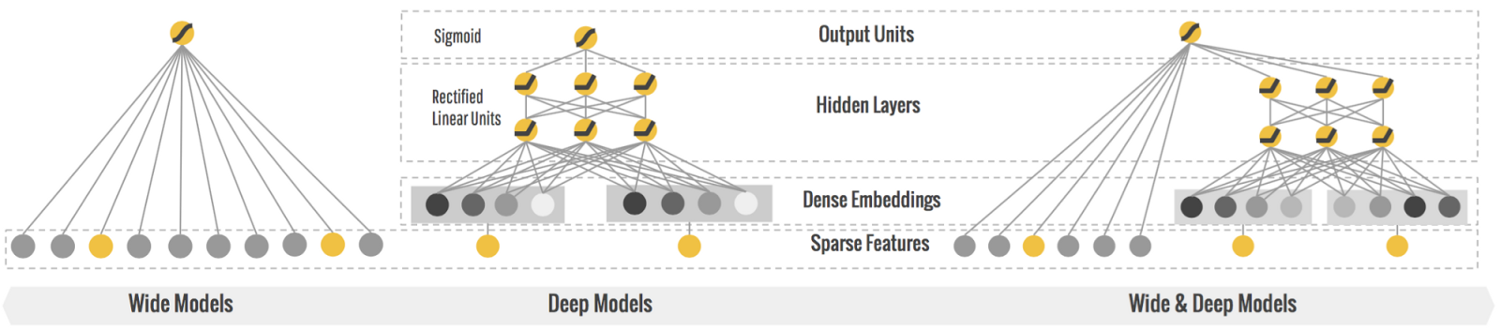

In [3]:
Image('./RNN_IMAGES/tf2.png')

## The Data 

유명한 Titanic Kaggle data를 이용할 것이다. Name, Sex, what ticket they had, the fare they paid the cabin they stayed in etc 등의 속성에 기반하여 승객의 생존 여부를 예측하는 예제이다.

먼저 우리는 우리의 컬럼을 Continuous or Categorial로 정의 해야한다.

In [7]:
CATEGORICAL_COLUMNS = ["Name", "Sex", "Embarked", "Cabin"]
CONTINUOUS_COLUMNS = ["Age", "SibSp", "Parch", "Fare", "PassengerId", "Pclass"]

Target : 생존 여부 (0 or 1) =>  Binary classification

In [5]:
SURVIVED_COLUMN = "Survived"

## The Network 

이제 컬럼을 만들고 embedding layer에 더한다. 우리는 모델을 만들 때 categorical columns를 sparse column으로 바꾸고 싶다! 

In [8]:
sex = tf.contrib.layers.sparse_column_with_keys(column_name="Sex",
                                                     keys=["female",
                                                 "male"])
embarked = tf.contrib.layers.sparse_column_with_keys(column_name="Embarked",
                                                   keys=["C",
                                                         "S",
                                                         "Q"])

각 카테고리를 정수로 매핑시킬 vocab file이 없기 때문에 word embedding을 한다?

In [9]:
cabin = tf.contrib.layers.sparse_column_with_hash_bucket(
      "Cabin", hash_bucket_size=1000)
name = tf.contrib.layers.sparse_column_with_hash_bucket(
      "Name", hash_bucket_size=1000)

continuous columns들은 실수를 사용한다. passengerID가 categorical 이 아니라 continuous인 이유는 그들은 string format이 아니라 integer ID를 사용하기 때문이다??

In [10]:
age = tf.contrib.layers.real_valued_column("Age")
passenger_id = tf.contrib.layers.real_valued_column("PassengerId")
sib_sp = tf.contrib.layers.real_valued_column("SibSp")
parch = tf.contrib.layers.real_valued_column("Parch")
fare = tf.contrib.layers.real_valued_column("Fare")
p_class = tf.contrib.layers.real_valued_column("Pclass")

Age는 구간을 가지기 때문에 bucket으로 만들어 자른다. Bucketization은 생존에 대한 상관계수를 특정 나이 전부가 아니라 어떤 나이대 그룹으로 가지게 만든다. 그러므로 정확도가 올라간다.

In [11]:
age_buckets = tf.contrib.layers.bucketized_column(age,
                                                    boundaries=[
                                                        5, 18, 25,
                                                        30, 35, 40,
                                                        45, 50, 55,
                                                        65
                                                    ])

이제 wide column과 deep columns으로 정의한다. 

* Wide columns : features 사이의 상호작용을 효과적으로 기억한다.
* Deep columns : features를 generalize 한다.

In [25]:
wide_columns = [sex, embarked, p_class, cabin, name, age_buckets,
                  tf.contrib.layers.crossed_column(
                      [age_buckets, sex],
                      hash_bucket_size=int(1e6)),
                  tf.contrib.layers.crossed_column([embarked, name],
                                                   hash_bucket_size=int(1e4))]

In [27]:
deep_columns = [
      tf.contrib.layers.embedding_column(sex, dimension=8),
      tf.contrib.layers.embedding_column(embarked, dimension=8),
      tf.contrib.layers.embedding_column(cabin, dimension=8),
      tf.contrib.layers.embedding_column(name, dimension=8),
      age,
      passenger_id,
      sib_sp,
      parch,
      fare,
  ]

In [31]:
import pandas as pd

## 전처리

In [35]:
# coding: utf-8

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Impute the missing ages with median age
train["Age"] = train["Age"].fillna(train["Age"].median()).astype(int)
test["Age"] = test["Age"].fillna(test["Age"].median()).astype(int)

# Fill in missing embarked with S
train["Embarked"] = train["Embarked"].fillna("S")
test["Embarked"] = test["Embarked"].fillna("S")

# Fill in missing Cabin with None
train["Cabin"] = train["Cabin"].fillna("None")
test["Cabin"] = test["Cabin"].fillna("None")

# Write our changed dataframes to csv.
test.to_csv("./data/test.csv", index=False)
train.to_csv('./data/train.csv', index=False)

## 모델 설계 

In [36]:
def build_estimator(model_dir):
  """Build an estimator."""
  # Categorical columns
  sex = tf.contrib.layers.sparse_column_with_keys(column_name="Sex",
                                                     keys=["female", "male"])
  embarked = tf.contrib.layers.sparse_column_with_keys(column_name="Embarked",
                                                   keys=["C",
                                                         "S",
                                                         "Q"])

  cabin = tf.contrib.layers.sparse_column_with_hash_bucket(
      "Cabin", hash_bucket_size=1000)
  name = tf.contrib.layers.sparse_column_with_hash_bucket(
      "Name", hash_bucket_size=1000)


  # Continuous columns
  age = tf.contrib.layers.real_valued_column("Age")
  passenger_id = tf.contrib.layers.real_valued_column("PassengerId")
  sib_sp = tf.contrib.layers.real_valued_column("SibSp")
  parch = tf.contrib.layers.real_valued_column("Parch")
  fare = tf.contrib.layers.real_valued_column("Fare")
  p_class = tf.contrib.layers.real_valued_column("Pclass")

  # Transformations.
  age_buckets = tf.contrib.layers.bucketized_column(age,
                                                    boundaries=[
                                                        5, 18, 25, 30, 35, 40,
                                                        45, 50, 55, 65
                                                    ])
   # Wide columns and deep columns.
  wide_columns = [sex, embarked, cabin, name, age_buckets,
                  tf.contrib.layers.crossed_column(
                      [age_buckets, sex],
                      hash_bucket_size=int(1e6)),
                  tf.contrib.layers.crossed_column([embarked, name],
                                                   hash_bucket_size=int(1e4))]
  deep_columns = [
      tf.contrib.layers.embedding_column(sex, dimension=8),
      tf.contrib.layers.embedding_column(embarked, dimension=8),
      tf.contrib.layers.embedding_column(cabin, dimension=8),
      tf.contrib.layers.embedding_column(name, dimension=8),
      age,
      passenger_id,
      sib_sp,
      parch,
      fare,
      p_class
  ]



  return tf.contrib.learn.DNNLinearCombinedClassifier(
        linear_feature_columns=wide_columns,
        dnn_feature_columns=deep_columns,
        dnn_hidden_units=[100, 50])

In [28]:
def input_fn(df, train=False):
  """Input builder function."""
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
  continuous_cols = {k: tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
    indices=[[i, 0] for i in range(df[k].size)],
    values=df[k].values,
    shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(continuous_cols)
  feature_cols.update(categorical_cols)
  # Converts the label column into a constant Tensor.
  if train:
    label = tf.constant(df[SURVIVED_COLUMN].values)
      # Returns the feature columns and the label.
    return feature_cols, label
  else:
    # so we can predict our results that don't exist in the csv
    return feature_cols

In [42]:
def train_and_eval():
  """Train and evaluate the model."""
  df_train = pd.read_csv(
      tf.gfile.Open("./data/train.csv"),
      skipinitialspace=True,engine='python')
  df_test = pd.read_csv(
      tf.gfile.Open("./data/test.csv"),
      skipinitialspace=True,engine='python')
  model_dir = "./titanic_models"
  print("model directory = %s" % model_dir)
  m = build_estimator(model_dir)
  m.fit(input_fn=lambda: input_fn(df_train, True), steps=200)
  print m.predict(input_fn=lambda: input_fn(df_test))
  results = m.evaluate(input_fn=lambda: input_fn(df_train, True), steps=1)
  for key in sorted(results):
    print("%s: %s" % (key, results[key]))

In [43]:
train_and_eval()

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be remove

model directory = ./titanic_models
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


accuracy: 0.627385
accuracy/baseline_target_mean: 0.383838
accuracy/threshold_0.500000_mean: 0.627385
auc: 0.513986
global_step: 200
labels/actual_target_mean: 0.383838
labels/prediction_mean: 0.0207029
loss: 49.8358
precision/positive_threshold_0.500000_mean: 0.777778
recall/positive_threshold_0.500000_mean: 0.0409357
